# Lesson 02: Exploring data with yt

<div class="alert alert-block alert-info">
 
## Goals:

* Exploring fields (min/max), the quantities interface
* Selecting regions of data
* slices and rays
* visualizing our selections
    
</div>

Now that we've learned a bit about how to load data with yt and what available objects there are in a field, we can use yt to perform analysis on those fields. 

### Exploring fields

First, let's explore some values that occur in our dat. For this tutorial we'll be using `enzo tiny cosmology`.

In [3]:
import yt
ds = yt.load_sample('enzo_tiny_cosmology')

yt : [INFO     ] 2020-03-23 00:56:57,135 Files located at /Users/madicken/yt_data/enzo_tiny_cosmology.tar.gz.untar/enzo_tiny_cosmology/
yt : [INFO     ] 2020-03-23 00:56:57,137 Default to loading DD0046/DD0046 for enzo_tiny_cosmology dataset
yt : [INFO     ] 2020-03-23 00:56:57,241 Parameters: current_time              = 230.66527489234
yt : [INFO     ] 2020-03-23 00:56:57,242 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2020-03-23 00:56:57,243 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-03-23 00:56:57,243 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2020-03-23 00:56:57,244 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-03-23 00:56:57,245 Parameters: current_redshift          = -2.7810863612032e-09
yt : [INFO     ] 2020-03-23 00:56:57,246 Parameters: omega_lambda              = 0.727
yt : [INFO     ] 2020-03-23 00:56:57,246 Parameters: omega_matter              = 0.273
yt : [INFO     ] 2020-03-2

This particular dataset is a *time series*. yt automatically loads the last file in a time series dataset; in this case it is `DD0046`.

Now let's explore a bit of the data contained in this file. First, let's see what fields we can explore:

In [4]:
ds.field_list

Parsing Hierarchy : 100%|██████████| 211/211 [00:00<00:00, 2442.16it/s]
yt : [INFO     ] 2020-03-23 00:57:00,483 Gathering a field list (this may take a moment.)


[('all', 'creation_time'),
 ('all', 'dynamical_time'),
 ('all', 'metallicity_fraction'),
 ('all', 'particle_index'),
 ('all', 'particle_mass'),
 ('all', 'particle_position_x'),
 ('all', 'particle_position_y'),
 ('all', 'particle_position_z'),
 ('all', 'particle_type'),
 ('all', 'particle_velocity_x'),
 ('all', 'particle_velocity_y'),
 ('all', 'particle_velocity_z'),
 ('enzo', 'Dark_Matter_Density'),
 ('enzo', 'Density'),
 ('enzo', 'Metal_Density'),
 ('enzo', 'Temperature'),
 ('enzo', 'TotalEnergy'),
 ('enzo', 'x-velocity'),
 ('enzo', 'y-velocity'),
 ('enzo', 'z-velocity'),
 ('io', 'creation_time'),
 ('io', 'dynamical_time'),
 ('io', 'metallicity_fraction'),
 ('io', 'particle_index'),
 ('io', 'particle_mass'),
 ('io', 'particle_position_x'),
 ('io', 'particle_position_y'),
 ('io', 'particle_position_z'),
 ('io', 'particle_type'),
 ('io', 'particle_velocity_x'),
 ('io', 'particle_velocity_y'),
 ('io', 'particle_velocity_z'),
 ('nbody', 'creation_time'),
 ('nbody', 'dynamical_time'),
 ('n

Great! That's a lot of fields. You might know that yt has a lot of tools in visualization, but it can also be used to inspect data. Here's an example where we find the extrema (the min and max) values of the "density" field. 

In [5]:
dd = ds.all_data()
dd.quantities.extrema("density")

unyt_array([1.59515116e-32, 2.56901687e-25], 'g/cm**3')

Ok, a few things have happened here. First, we've done this operation `ds.all_data()` which returns a *region* in yt based on the domain boundaries detected when the data was read in. We've returned all of the data in this dataset. 

We can check this by inspecting the `dd` object, which is a `YTRegion`. 

In [6]:
dd

YTRegion (DD0046): , center=[7.03288339e+25 7.03288339e+25 7.03288339e+25] cm, left_edge=[0. 0. 0.] cm, right_edge=[1.40657668e+26 1.40657668e+26 1.40657668e+26] cm

Region objects (and in fact any selection of the data) have **quantites** that we can use on them, but they need to be a type data selection. In the previous example, we accessed the `extrema` quantity, whcih returns a unyt array of length two of the minimum and maximum values in the density field of this dataset. 

Let's see what other quantities are available: 

In [7]:
print (list(dd.quantities.keys()))

['WeightedAverageQuantity', 'TotalQuantity', 'TotalMass', 'CenterOfMass', 'BulkVelocity', 'WeightedVariance', 'AngularMomentumVector', 'Extrema', 'SampleAtMaxFieldValues', 'MaxLocation', 'SampleAtMinFieldValues', 'MinLocation', 'SpinParameter']


ok, now let's examine what arguments we need to pass to get something we want. How about `WeightedAverageQuantity`

In [8]:
dd.quantities.weighted_average_quantity?

Signature:      dd.quantities.weighted_average_quantity(fields, weight)
Type:           WeightedAverageQuantity
String form:    <yt.data_objects.derived_quantities.WeightedAverageQuantity object at 0x112bd41d0>
File:           ~/repos/yt/yt/data_objects/derived_quantities.py
Docstring:     
Calculates the weight average of a field or fields.

Returns a YTQuantity for each field requested; if one,
it returns a single YTQuantity, if many, it returns a list of YTQuantities
in order of the listed fields.

Where f is the field and w is the weight, the weighted average is
Sum_i(f_i \* w_i) / Sum_i(w_i).

Parameters
----------

fields : string / tuple, or list of strings / tuples
    The field or fields of which the average value is to be calculated.
weight : string or tuple
    The weight field.

Examples
--------

>>> ds = load("IsolatedGalaxy/galaxy0030/galaxy0030")
>>> ad = ds.all_data()
>>> print(ad.quantities.weighted_average_quantity([("gas", "density"),
...                            

and now let's calculate the temperature weighted density of this dataset:

In [9]:
dd.quantities.weighted_average_quantity("density", weight="temperature")

unyt_quantity(8.80691103e-28, 'g/cm**3')

we can also pass a list of fields with which to calculate a weighted average quantity

In [10]:
dd.quantities.weighted_average_quantity(["density", "temperature"], weight="temperature")

[unyt_quantity(8.80691103e-28, 'g/cm**3'),
 unyt_quantity(4431128.78427079, 'K')]

<div class="alert alert-block alert-warning">

## Interactive Exercise 01
    
Load in the dataset `enzo_cosmology_plus` and find the  following quantities:
    
* min and maximum values of each `enzo` field in the entire dataset
* the total gas mass in the dataset
* the `cell_volume` weighted average density
* the location of the min and max values 
    

</div>

In [ ]:
# This is starting cell to do exercise 01

<div class="alert alert-block alert-success">
 
### Tips:
    
* instead of doing `dd = ds.all_data()` and then selecting data with dens = dd["density"], yt has the option to do an automatioc `region selector` with `dens = ds.r["density"]`. `ds.r()` is a `RegionExpression` object and doesn't have any quantities associated with it. When used with a field argument, this function returns a flattened array of the data. 
* for this tutorial we've only loaded in the last file `DD0046`. However, because this is a time-series dataset there are a number of other files. yt can recognize this by loading with wildcard operators. e.g. `ts = yt.load("enzo_tiny_cosmology/DD????/DD????")`. 

</div>

## Volumetric Region Selectors

So far we've loaded in the entire dataset with `all_data()`. We learned that this is a special function that returns a YTRegion that spans the entire domain of the data. However, yt has other data selectors that are available, like `sphere`. Let's do a region selection of the entire dataset manually and check that the values are the same as what we saw in the first section. 

In [13]:
bx = ds.box([0.,0.,0.], [1.,1.,1.]) 
# we could also specify a center and use ds.region(). ds.box() assumes the center of this prism is the 
# centerpoint of the left and right edges. 

In [14]:
bx

YTRegion (DD0046): , center=[7.03288339e+25 7.03288339e+25 7.03288339e+25] cm, left_edge=[0. 0. 0.] cm, right_edge=[1.40657668e+26 1.40657668e+26 1.40657668e+26] cm

bx is a YTRegion object, which is what would be returned had we used the `ds.region()` selector as well. Let's compare it to the dd object we used before. 

In [15]:
dd 

YTRegion (DD0046): , center=[7.03288339e+25 7.03288339e+25 7.03288339e+25] cm, left_edge=[0. 0. 0.] cm, right_edge=[1.40657668e+26 1.40657668e+26 1.40657668e+26] cm

They look the same at first pass! Let's see what happens if we look at the min, the max, and a random weighted field! 

In [19]:
print(bx.quantities.extrema('temperature'))
print(dd.quantities.extrema('temperature'))

[1.0000000e+00 2.3541198e+07] K
[1.0000000e+00 2.3541198e+07] K


In [18]:
print(bx.quantities.weighted_average_quantity('temperature', weight='ones'))
print(dd.quantities.weighted_average_quantity('temperature', weight='ones'))

713182.6390915675 K
713182.6390915675 K


Ok! So now we can be reasonably sure that the way we selected data with `ds.all_data()` is a nice shorthand to select all data in our dataset. However, we can create the same object with `box()`

Now let's do a region selector with a sphere. 

In [21]:
ds.sphere?

Signature:       ds.sphere(center, radius, *, ds=<weakproxy at 0x10fe8d908 to EnzoDataset at 0x104a7d9e8>, field_parameters=None, data_source=None)
Call signature:  ds.sphere(*args, **kwargs)
Type:            partial
String form:     functools.partial(<class 'yt.data_objects.selection_data_containers.YTSphere'>, ds=<weakproxy at 0x10fe8d908 to EnzoDataset at 0x104a7d9e8>)
File:            ~/python/anaconda/envs/ytdev/lib/python3.6/functools.py
Docstring:      
A sphere of points defined by a *center* and a *radius*.

Parameters
----------
center : array_like
    The center of the sphere.
radius : float, width specifier, or YTQuantity
    The radius of the sphere. If passed a float,
    that will be interpreted in code units. Also
    accepts a (radius, unit) tuple or YTQuantity
    instance with units attached.

Examples
--------

>>> import yt
>>> ds = yt.load("RedshiftOutput0005")
>>> c = [0.5,0.5,0.5]
>>> sphere = ds.sphere(c, (1., "kpc"))
Class docstring:
partial(func, *args, **key

Ok, so let's define a centerpoint at 0.5, 0.5, 0.5 in code units and extend the sphere outwards to 0.25 code units. 

In [22]:
center = [0.5, 0.5, 0.5]
sp = ds.sphere(center , 0.25) 

Is the sphere a YTRegion object like the selector we saw before? Nope! It's a YTSphere. Both are subclasses of the same type of yt selector object and so have similar operations available to them though. 

In [23]:
sp

YTSphere (DD0046): , center=[7.03288339e+25 7.03288339e+25 7.03288339e+25] cm, radius=3.5164416974858815e+25 cm

Let's take a look at the extrema and compare them to what we saw in the larger dataset! 

In [24]:
print(sp.quantities.extrema('density'))
print(dd.quantities.extrema('density'))

[1.89495189e-32 2.63364632e-26] g/cm**3
[1.59515116e-32 2.56901687e-25] g/cm**3


In [25]:
print(sp.quantities.weighted_average_quantity('density', weight='cell_volume'))
print(dd.quantities.weighted_average_quantity('density', weight='cell_volume'))

4.998599259223583e-31 g/cm**3
4.182089317585737e-31 g/cm**3


In [26]:
print(sp.mean('density', weight='cell_volume'))
print(dd.mean('density', weight='cell_volume'))

4.998599259223583e-31 g/cm**3
4.182089317585737e-31 g/cm**3


<div class="alert alert-block alert-warning">

## Interactive Exercise 02
    
With your previously loaded dataset `enzo_cosmology_plus` and select a region (from the available options [in the docs](https://yt-project.org/doc/analyzing/objects.html#region-reference)) in the domain center with random dimensions. 
    
Now compare the total gas mass, the min, and the max values of the density field for the region you've selected to that of the total dataset that you did in exercise 01. Do they differ? Do they look the same? 
</div>

In [ ]:
# This is a starting cell to do exercise 02 

<div class="alert alert-block alert-success">
 
### Tips:
    
* `obj.mean()`, `.min()`, and `.max()` are easy accessors for `.quantiy.weighted_average_quantity()`, and `.quantity.extrema()`
* The way this tutorial has specified the left, right, and center of the object is in code units, which generally span from 0 to 1. However, you can use any unit quantity you'd like thanks to yt's unit interface. Maybe you'd like to use MPc instead? No problem! Try `sp = ds.sphere(center, (10, 'Mpc'))`

</div>

## Rays and Slices 

So far we've seen some volumetric selector objects and how we can calculate different things on those object with the quantities interface. These are very useful to get intuitions into our data! We can find out a lot about what's going on in our fields by using these selectors. 

However, yt has other selector objects that can give us insight into our data. Let's start with `ray` objects. We can define a path through our data with a starting point and an ending point. 

In [31]:
ds.ray?

Signature:       ds.ray(start_point, end_point, *, ds=<weakproxy at 0x10fe8d908 to EnzoDataset at 0x104a7d9e8>, field_parameters=None, data_source=None)
Call signature:  ds.ray(*args, **kwargs)
Type:            partial
String form:     functools.partial(<class 'yt.data_objects.selection_data_containers.YTRay'>, ds=<weakproxy at 0x10fe8d908 to EnzoDataset at 0x104a7d9e8>)
File:            ~/python/anaconda/envs/ytdev/lib/python3.6/functools.py
Docstring:      
This is an arbitrarily-aligned ray cast through the entire domain, at a
specific coordinate.

This object is typically accessed through the `ray` object that hangs
off of index objects.  The resulting arrays have their
dimensionality reduced to one, and an ordered list of points at an
(x,y) tuple along `axis` are available, as is the `t` field, which
corresponds to a unitless measurement along the ray from start to
end.

Parameters
----------
start_point : array-like set of 3 floats
    The place where the ray starts.
end_point : 

In [38]:
ra = ds.ray([0.1, 0.2, 0.3], [0.9, 0.8, 0.7])

In [39]:
ra

YTRay (DD0046): , start_point=[1.40657668e+25 2.81315336e+25 4.21973004e+25] cm, end_point=[1.26591901e+26 1.12526134e+26 9.84603675e+25] cm

We can plot this with matplotlib if we'd like. 

In [33]:
import matplotlib.pyplot as plt

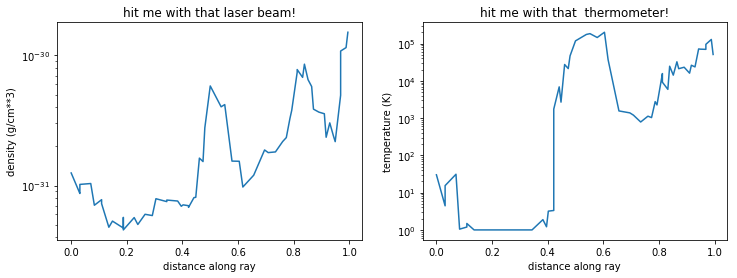

In [48]:
t = ra['t']
dens = ra['density']
temp = ra['temperature']
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax1.plot(t, dens)
ax1.set_yscale('log')
ax1.set(xlabel='distance along ray', ylabel='density (g/cm**3)',
       title='hit me with that laser beam!')

ax2.plot(t, temp)
ax2.set_yscale('log')
ax2.set(xlabel='distance along ray', ylabel='temperature (K)',
       title='hit me with that  thermometer!')
plt.show()

We can also use the same `quantity` accessors that we used before! 

In [51]:
print(ra.quantities.extrema('density'))
print(ra.quantities.extrema('temperature'))

[4.55720104e-32 2.77562357e-31] g/cm**3
[1.00000000e+00 4.67219727e+04] K


Rays are a good way to gain intuition to what our data looks like along a specific path. This might be hard to immediately glean by inspecting values or visualizing the whole dataset. 

We can also create 2d data objects, such as a `slice`! 

In [52]:
ds.slice?

Signature:       ds.slice(axis, coord, center=None, *, ds=<weakproxy at 0x10fe8d908 to EnzoDataset at 0x104a7d9e8>, field_parameters=None, data_source=None)
Call signature:  ds.slice(*args, **kwargs)
Type:            partial
String form:     functools.partial(<class 'yt.data_objects.selection_data_containers.YTSlice'>, ds=<weakproxy at 0x10fe8d908 to EnzoDataset at 0x104a7d9e8>)
File:            ~/python/anaconda/envs/ytdev/lib/python3.6/functools.py
Docstring:      
This is a data object corresponding to a slice through the simulation
domain.

This object is typically accessed through the `slice` object that hangs
off of index objects.  Slice is an orthogonal slice through the
data, taking all the points at the finest resolution available and then
indexing them.  It is more appropriately thought of as a slice
'operator' than an object, however, as its field and coordinate can
both change.

Parameters
----------
axis : int or char
    The axis along which to slice.  Can be 0, 1, or 2 f

In [53]:
sl1 = ds.slice('z', 0.4)

In [54]:
sl1

YTSlice (DD0046): , axis=2, coord=0.4

In [58]:
print(sl1.min('density'))
print(sl1.max('density'))
print(sl1.mean('density'))

1.877701301664009e-32 g/cm**3
7.712385169116562e-28 g/cm**3
5.832813891782659e-30 g/cm**3


We can also do things like [off-axis slices](https://yt-project.org/docs/dev/quickstart/data_objects_and_time_series.html#Off-Axis-Slices)

In [59]:
ds.cutting?

Signature:       ds.cutting(normal, center, north_vector=None, *, ds=<weakproxy at 0x10fe8d908 to EnzoDataset at 0x104a7d9e8>, field_parameters=None, data_source=None)
Call signature:  ds.cutting(*args, **kwargs)
Type:            partial
String form:     functools.partial(<class 'yt.data_objects.selection_data_containers.YTCuttingPlane'>, ds=<weakproxy at 0x10fe8d908 to EnzoDataset at 0x104a7d9e8>)
File:            ~/python/anaconda/envs/ytdev/lib/python3.6/functools.py
Docstring:      
This is a data object corresponding to an oblique slice through the
simulation domain.

This object is typically accessed through the `cutting` object
that hangs off of index objects.  A cutting plane is an oblique
plane through the data, defined by a normal vector and a coordinate.
It attempts to guess an 'north' vector, which can be overridden, and
then it pixelizes the appropriate data onto the plane without
interpolation.

Parameters
----------
normal : array_like
    The vector that defines the des

In [69]:
sl2 = ds.cutting([0.2, 0.3, 0.5], "min")

yt : [INFO     ] 2020-03-23 02:14:00,639 Min Value is 1.59515e-32 at 0.1406250000000000 0.2968750000000000 0.6406250000000001


In [70]:
sl2

YTCuttingPlane (DD0046): , normal=[0.32444284 0.48666426 0.81110711] dimensionless, center=[1.97799845e+25 4.17577452e+25 9.01088185e+25] cm

In [71]:
print(sl2.min('density'))
print(sl2.max('density'))
print(sl2.mean('density'))

1.5951511552999262e-32 g/cm**3
5.043155806535799e-28 g/cm**3
4.636210020145791e-30 g/cm**3


<div class="alert alert-block alert-warning">

## Interactive Exercise 03
    
* Find the locations of the maximum and minumum values in the temperature field of `enzo cosmology plus` and create a ray with it. How do the quantity values of the ray compare to the shape you created in exercise 02? 
* Create a slice object at an arbitrary location with this dataset. 
    
</div>

In [49]:
# This is a cell to start for exercise 03 

<div class="alert alert-block alert-success">
 
### Tips:
    
* `ds.r()` gives us shorthand notation to slice our data without using the `slice()` method. For example `ds.r[:,:, 0.5]` will return a YTSlice object at the z midplane of the dataset. 

</div>

## Visualizing our Selections and Advanced Selections

The `.plot()` method is an easily accessible way for us to visualize the selections we've been doing with our data. Let's try them out on the objects we've already created in the previous selection. 

yt : [INFO     ] 2020-03-23 02:19:41,297 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-03-23 02:19:41,299 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-03-23 02:19:41,302 Making a fixed resolution buffer of (density) 800 by 800
yt : [INFO     ] 2020-03-23 02:19:41,307 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2020-03-23 02:19:41,315 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



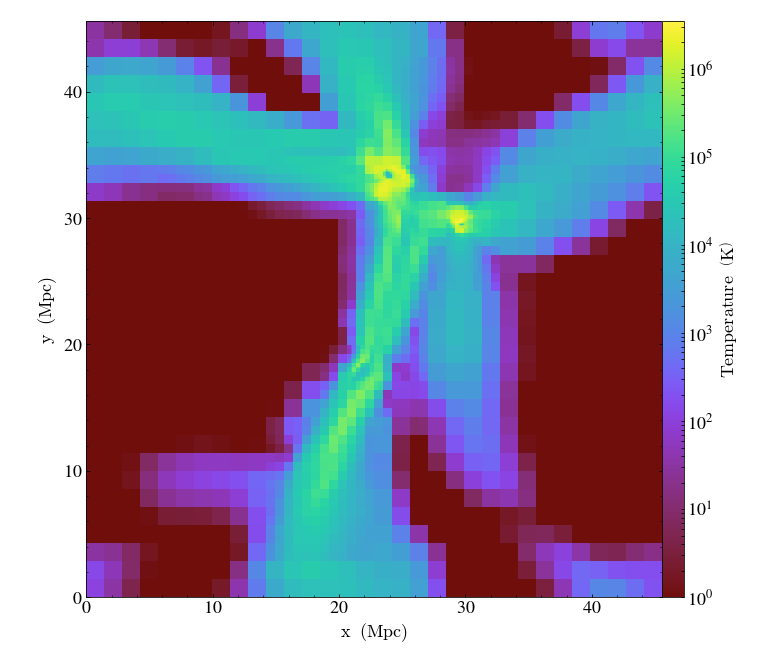
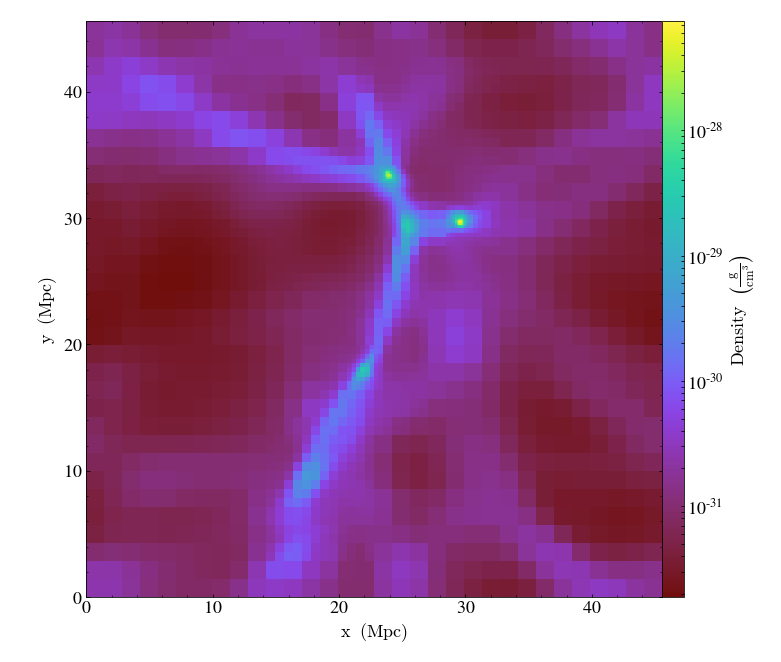


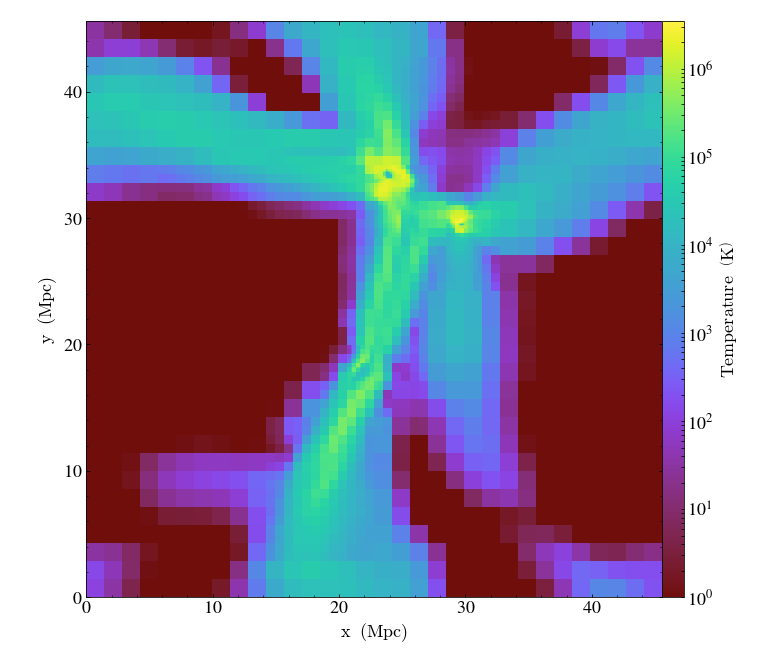
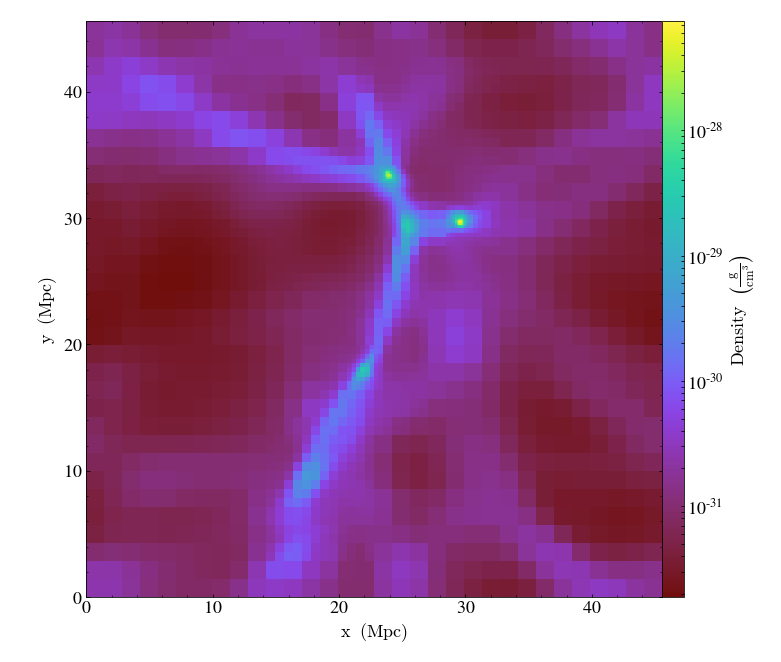

In [82]:
p1 = sl1.plot('density')
p1.show()

yt : [INFO     ] 2020-03-23 02:19:18,518 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-03-23 02:19:18,520 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-03-23 02:19:18,523 Making a fixed resolution buffer of (temperature) 800 by 800
yt : [INFO     ] 2020-03-23 02:19:18,530 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2020-03-23 02:19:18,538 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



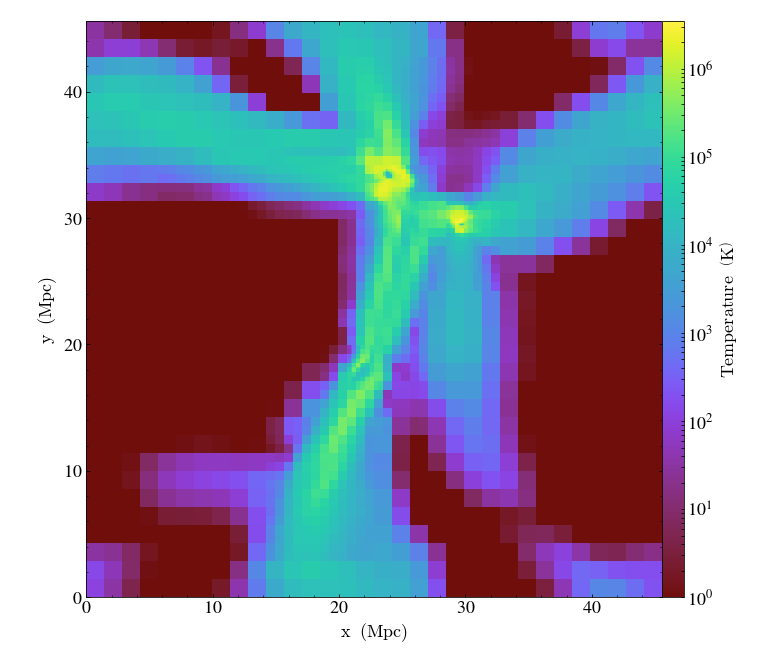
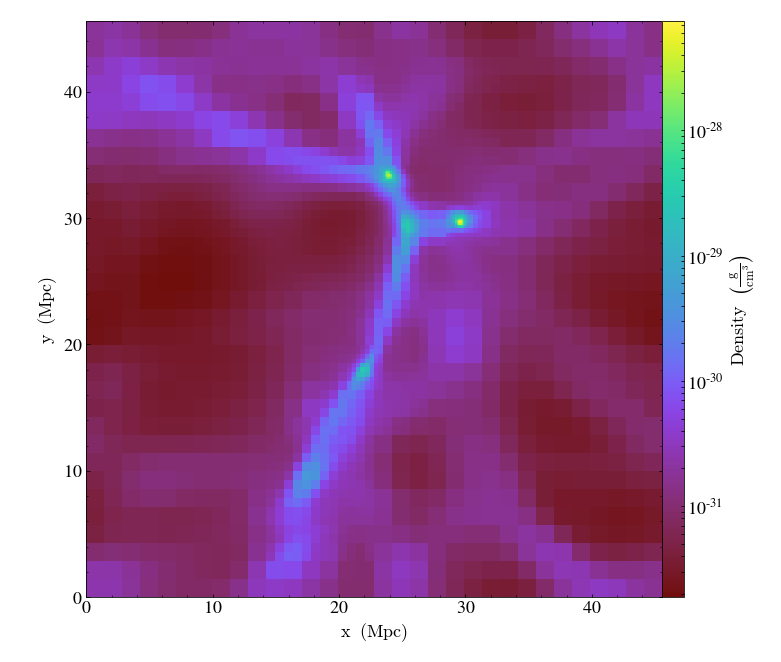


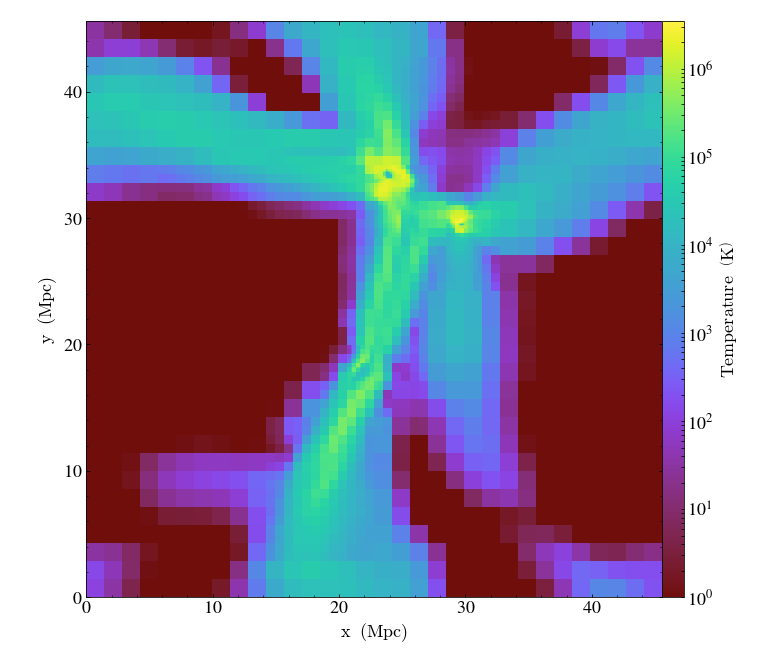
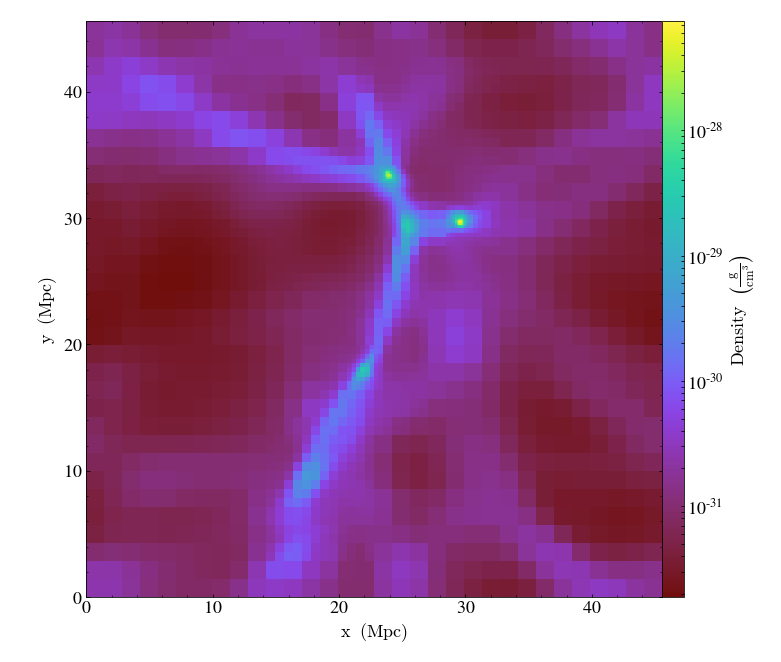

In [81]:
p2 = sl1.plot('temperature')
p2.show()

We can also use volume selectors in slices to do some more advanced data selection. Let's use a sphere and a slice together and see what that looks like! 

yt : [INFO     ] 2020-03-23 02:26:19,515 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-03-23 02:26:19,517 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-03-23 02:26:19,519 Making a fixed resolution buffer of (density) 800 by 800
yt : [INFO     ] 2020-03-23 02:26:19,630 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



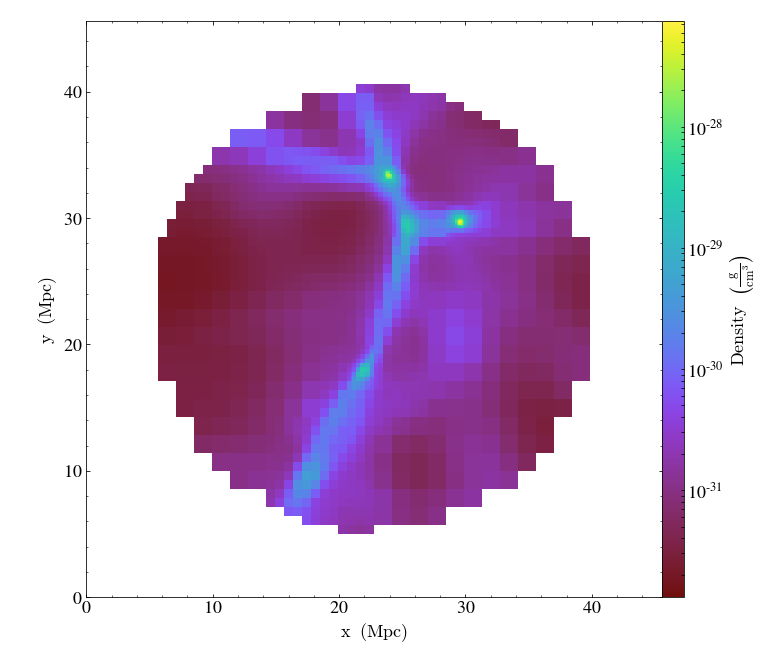


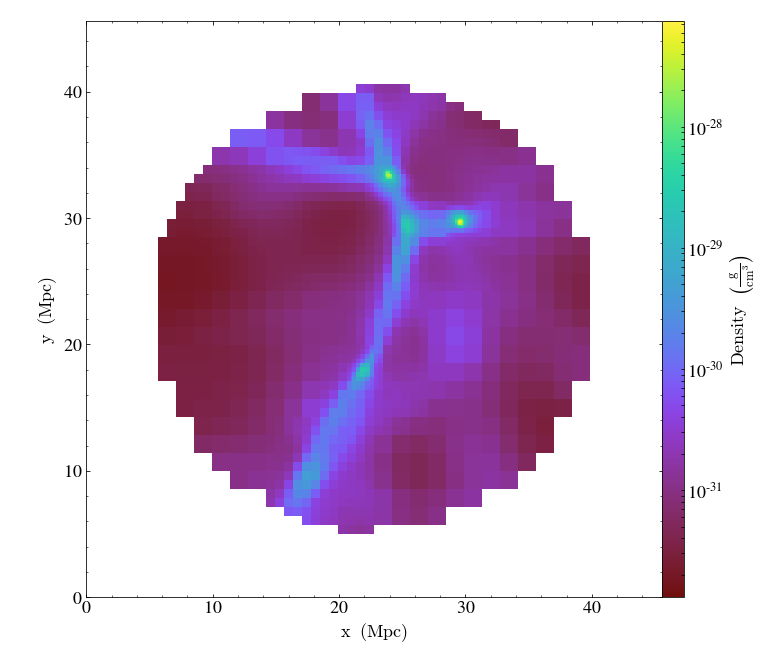

In [84]:
sp2 = ds.sphere(center, 0.4) 
sl3 = ds.slice('z', 0.4, data_source=sp2)
p3 = sl3.plot('density')
p3.show()

We can even chain together volumes with an union and plot that! 

In [96]:
sp3 = ds.sphere([0.4, 0.5, 0.5], 0.18)
sp4 = ds.sphere([0.7, 0.65, 0.5], 0.28)

yt : [INFO     ] 2020-03-23 02:31:57,955 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-03-23 02:31:57,956 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-03-23 02:31:57,958 Making a fixed resolution buffer of (temperature) 800 by 800
yt : [INFO     ] 2020-03-23 02:31:58,037 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



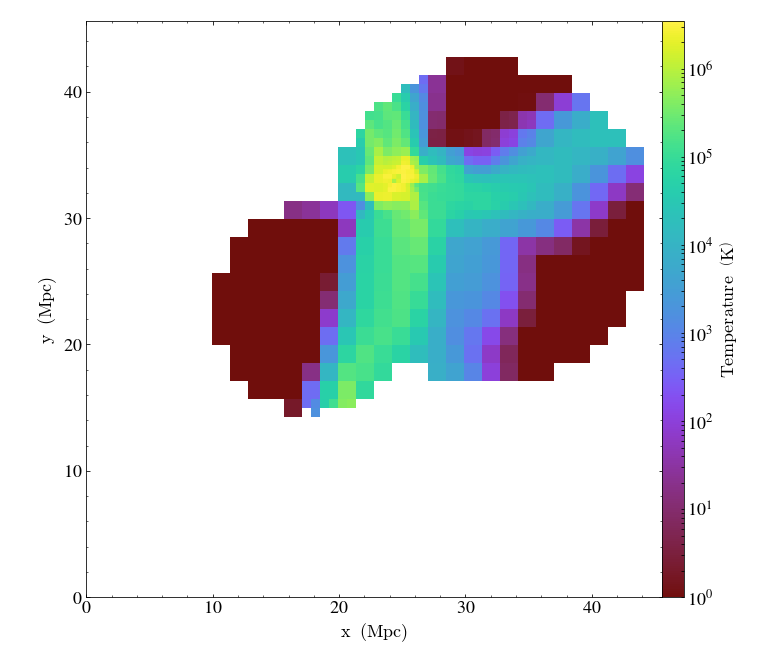


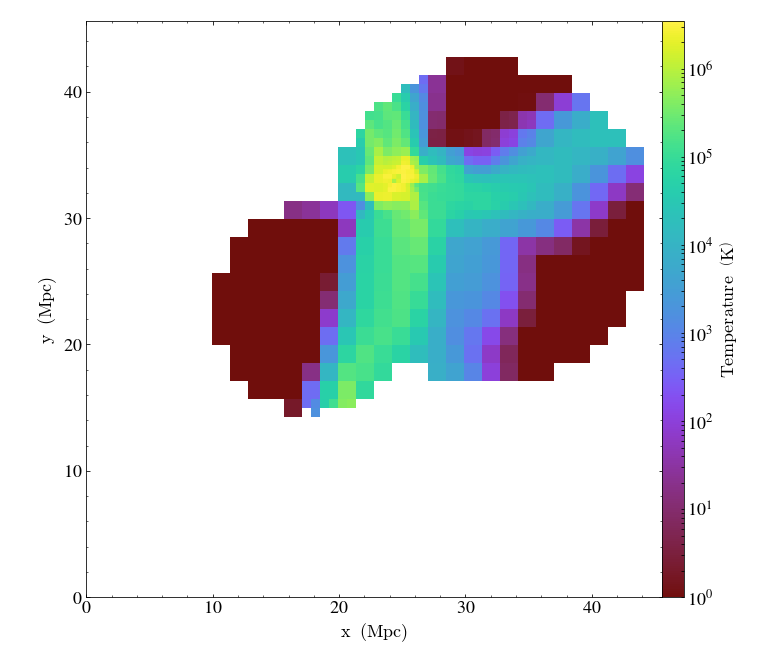

In [97]:
isp = ds.union( [sp3, sp4] )
sl4 = ds.slice('z', 0.5, data_source=isp)
p4 = sl4.plot('temperature')
p4.show()

<div class="alert alert-block alert-warning">

## Interactive Exercise 04
    
* create a a slice object object in the `temperature` field and visualize it with the .plot() object. 
* bonus: create an intersection object with a slice object and the volumetric object you made in exercise 03 and visualize that! 
</div>

In [ ]:
# This is a cell to start exercise 04

<div class="alert alert-block alert-success">
 
### Tips:
    
* .plot() works yt slice and projection objects
* you can visualize a volumetric object by passing it through the `data_source` arg of a slice. However, you need to be careful that the regions actually intersect, or else your returned object will be all zeroes! 
* Another type of selection that wasn't covered in this tutorial is a [Profile](https://yt-project.org/docs/dev/quickstart/derived_fields_and_profiles.html) object. If you have time, try to create one! 
* Another type of object we didn't create was a projection! Try it out. 
* more plotting will happen in the next lesson! 

</div>

<div class="alert alert-block alert-danger">

## Bringing It All Together: Challenge Exercise
    
With `enzo_cosmology_plus`, create an intersection object composed of a disk and a sphere at arbitrary locations in the data (make sure they overlap). Then make a slice of this object at its midpoint and visualize it with `.plot()`. Calculate the total mass of each object you created. 
</div>

In [53]:
# This is a starting cell to do the challenge exercise

# Takeaways

<div class="alert alert-block alert-success">

### There are many ways we can do the same operation with yt
### Derived quantities can be calculated on YT selection objects. These objects can be:
    
* [geometric](https://yt-project.org/doc/analyzing/objects.html#geometric-objects) (object is based on geometry)
* [filtering objects](https://yt-project.org/doc/analyzing/objects.html#filtering-and-collection-objects) (object is based on field criteria)
* [construction objects](https://yt-project.org/doc/analyzing/objects.html#construction-objects) (data is based on additional analysis)
* [collections](https://yt-project.org/doc/analyzing/objects.html#filtering-and-collection-objects) (object is a collection of other objects).
    
### Slice objects can be visualized with the `.plot()` method 

</div>